In [1]:
%pip install dse_do_utils

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
def continuous_var_series(df, mdl,**kargs):
    return pd.Series(mdl.continuous_var_list(df.index, **kargs), index = df.index)

def binary_var_series(df, mdl,**kargs):
    return pd.Series(mdl.binary_var_list(df.index, **kargs), index = df.index)

def integer_var_series(df, mdl,**kargs):
    '''Create a Series of integer dvar for each row in the DF. Most effective method. Best practice.
    Result can be assigned to a column of the df.
    Usage:
        df['xDVar'] = mdl.integer_var_series(df, name = 'xDVar')
    Args:
        mdl: CPLEX Model
        df: DataFrame
        **kargs: arguments passed to mdl.integer_var_list method. E.g. 'name'
        
    :returns: pandas.Series with integer dvars, index matches index of df
    '''
    #We are re-using the index from the DF index:
    return pd.Series(mdl.integer_var_list(df.index, **kargs), index = df.index)

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = [4.5, 3]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
import numpy as np
import pandas as pd

from dse_do_utils import OptimizationEngine,ScenarioManager
import docplex.mp
from docplex.mp.model import Model

In [3]:
MODEL_NAME = 'ToyVRP'
SCENARIO_NAME = 'scenario_1' 
sm = ScenarioManager(model_name=MODEL_NAME, scenario_name=SCENARIO_NAME)

sm.InputTables={}

In [4]:
number_of_clientes = 4
number_of_depots = 1
number_of_locations = number_of_clientes + number_of_depots
number_of_trucks = 1
Truck_capacity= 20

In [5]:
Demand = pd.DataFrame([])
Demand["Name"] = ["Client_" +str(i) for i in range(1,number_of_clientes+1)]
Demand["Quantity"]  = [np.random.randint(1, 10) for i in range(1,number_of_clientes+1)]
display(Demand.head())

Depots = pd.DataFrame([])
Depots["Name"]=["Depot_" +str(i) for i in range(1,number_of_depots+1)]
display(Depots.head())

Locations = pd.DataFrame([])
Locations["Name"] = np.concatenate([Demand["Name"].values , Depots["Name"].values])
Locations["Latitude"] = np.random.rand(number_of_locations)*200
Locations["Longitude"] = np.random.rand(number_of_locations)*100
Locations["Type"]= ["Client" for i in range(0,number_of_clientes)] + ["Depot" for i in range(0,number_of_depots)] 
display(Locations.head())


Trucks = pd.DataFrame([])
Trucks["Name"] = ["Truck_" +str(i) for i in range(1,number_of_trucks+1)]
Trucks["Capacity"] = Truck_capacity
display(Trucks.head())


sm.InputTables['Demand']=Demand
sm.InputTables['Depots']=Depots
sm.InputTables['Locations']=Locations
sm.InputTables['Trucks']=Trucks

,Name,Quantity
0,Client_1,3
1,Client_2,8
2,Client_3,3
3,Client_4,2


,Name
0,Depot_1


,Name,Latitude,Longitude,Type
0,Client_1,99.514671,40.861946,Client
1,Client_2,46.497226,54.695061,Client
2,Client_3,117.346835,99.431327,Client
3,Client_4,88.177665,1.412681,Client
4,Depot_1,45.680807,31.018604,Depot


,Name,Capacity
0,Truck_1,20


In [6]:
All = []
for i in Locations["Name"]:
    for j in Locations["Name"]:
        if i!=j:
            Origin= Locations[Locations["Name"]==i] 
            Destination= Locations[Locations["Name"]==j] 
            
            distance = np.hypot(  Destination["Latitude"].values[0] - Origin["Latitude"].values[0] ,  Destination["Longitude"].values[0] - Origin["Longitude"].values[0])
            All.append([i,j,distance])
Distances  = pd.DataFrame(All, columns = ["Origin","Destination",'Distance'])   
display(Distances.head(3))

sm.InputTables['Distances']=Distances

,Origin,Destination,Distance
0,Client_1,Client_2,54.792376
1,Client_1,Client_3,61.223839
2,Client_1,Client_4,41.045977


In [7]:
sm.InputTables.keys()

dict_keys(['Demand', 'Depots', 'Locations', 'Trucks', 'Distances'])

In [8]:

mdl = Model(name='Toy_VRP')

In [9]:
Paths = sm.InputTables['Distances']
Paths= Paths.set_index(["Origin","Destination"])
Paths["xPath"] = binary_var_series(Paths, mdl,name = 'x')

Paths.head()

Distance                xPath
Origin   Destination                                
Client_1 Client_2     54.792376  x_Client_1_Client_2
         Client_3     61.223839  x_Client_1_Client_3
         Client_4     41.045977  x_Client_1_Client_4
         Depot_1      54.726376   x_Client_1_Depot_1
Client_2 Client_1     54.792376  x_Client_2_Client_1

In [10]:
Cum_Demand = sm.InputTables['Demand'].set_index("Name")

Cum_Demand["Cum_Demand"] = continuous_var_series(Cum_Demand, mdl, name = "CD", ub= Truck_capacity)
Cum_Demand

,Quantity,Cum_Demand
Name,,
Client_1,3,CD_Client_1
Client_2,8,CD_Client_2
Client_3,3,CD_Client_3
Client_4,2,CD_Client_4


go to a single client j and when we reach that client we must have arrived from a single node either the depot or the predecessor client i.

In [11]:
for origin, group in Paths.groupby("Origin"):
    mdl.add_constraint(   mdl.sum( group.xPath )  == 1 )

go to a single client i and when we reach that client we must have arrived from a single node either the depot or the predecessor client j.

In [12]:
for Destination, group in Paths.groupby("Destination"):
    mdl.add_constraint(   mdl.sum( group.xPath )  == 1 )

In [13]:
total_cost = mdl.sum(Paths["Distance"]*Paths["xPath"])
mdl.add_kpi(total_cost,"total_cost")

DecisionKPI(name=total_cost,expr=54.792x_Client_1_Client_2+61.224x_Client_1_Client_3+41.046x_Clie..)

In [14]:
mdl.minimize(total_cost)
mdl.print_information()

Model: Toy_VRP
 - number of variables: 24
   - binary=20, integer=0, continuous=4
 - number of constraints: 10
   - linear=10
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP
Model: Toy_VRP
 - number of variables: 24
   - binary=20, integer=0, continuous=4
 - number of constraints: 10
   - linear=10
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP


In [15]:
solution = mdl.solve(log_output=True)
assert solution, "solve failed"
mdl.report()

Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d


CPXPARAM_Read_DataCheck                          1
CPXPARAM_Read_DataCheck                          1


Tried aggregator 1 time.
Tried aggregator 1 time.


MIP Presolve eliminated 0 rows and 4 columns.
MIP Presolve eliminated 0 rows and 4 columns.


Reduced MIP has 10 rows, 20 columns, and 40 nonzeros.
Reduced MIP has 10 rows, 20 columns, and 40 nonzeros.


Reduced MIP has 20 binaries, 0 generals, 0 SOSs, and 0 indicators.
Reduced MIP has 20 binaries, 0 generals, 0 SOSs, and 0 indicators.


Presolve time = 0.00 sec. (0.02 ticks)
Presolve time = 0.00 sec. (0.02 ticks)


Found incumbent of value 315.147971 after 0.00 sec. (0.06 ticks)
Found incumbent of value 315.147971 after 0.00 sec. (0.06 ticks)


Probing time = 0.00 sec. (0.01 ticks)
Probing time = 0.00 sec. (0.01 ticks)


Tried aggregator 1 time.
Tried aggregator 1 time.


Detecting symmetries...
Detecting symmetries...


Reduced MIP has 10 rows, 20 columns, and 40 nonzeros.
Reduced MIP has 10 rows, 20 columns, and 40 nonzeros.


Reduced MIP has 20 binaries, 0 generals, 0 SOSs, and 0 indicators.
Reduced MIP has 20 binaries, 0 generals, 0 SOSs, and 0 indicators.


Presolve time = 0.02 sec. (0.03 ticks)
Presolve time = 0.02 sec. (0.03 ticks)


Probing time = 0.00 sec. (0.01 ticks)
Probing time = 0.00 sec. (0.01 ticks)


Clique table members: 10.
Clique table members: 10.


MIP emphasis: balance optimality and feasibility.
MIP emphasis: balance optimality and feasibility.


MIP search method: dynamic search.
MIP search method: dynamic search.


Parallel mode: deterministic, using up to 8 threads.
Parallel mode: deterministic, using up to 8 threads.


Root relaxation solution time = 0.00 sec. (0.02 ticks)
Root relaxation solution time = 0.00 sec. (0.02 ticks)



        Nodes                                         Cuts/


        Nodes                                         Cuts/


   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap



*     0+    0                          315.1480        0.0000           100.00%
*     0+    0                          315.1480        0.0000           100.00%


*     0+    0                          251.9177        0.0000           100.00%
*     0+    0                          251.9177        0.0000           100.00%


      0     0        cutoff            251.9177      251.9177        6    0.00%
      0     0        cutoff            251.9177      251.9177        6    0.00%


      0     0        cutoff            251.9177      251.9177        6    0.00%
      0     0        cutoff            251.9177      251.9177        6    0.00%


Elapsed time = 0.03 sec. (0.18 ticks, tree = 0.01 MB, solutions = 2)
Elapsed time = 0.03 sec. (0.18 ticks, tree = 0.01 MB, solutions = 2)



Root node processing (before b&c):


Root node processing (before b&c):


  Real time             =    0.03 sec. (0.18 ticks)
  Real time             =    0.03 sec. (0.18 ticks)


Parallel b&c, 8 threads:
Parallel b&c, 8 threads:


  Real time             =    0.00 sec. (0.00 ticks)
  Real time             =    0.00 sec. (0.00 ticks)


  Sync time (average)   =    0.00 sec.
  Sync time (average)   =    0.00 sec.


  Wait time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.


                          ------------
                          ------------


Total (root+branch&cut) =    0.03 sec. (0.18 ticks)
Total (root+branch&cut) =    0.03 sec. (0.18 ticks)


* model Toy_VRP solved with objective = 251.918
*  KPI: total_cost = 251.918
* model Toy_VRP solved with objective = 251.918
*  KPI: total_cost = 251.918


In [16]:
print(solution)

solution for: Toy_VRP
objective: 251.918
status: OPTIMAL_SOLUTION(2)
x_Client_1_Client_4=1
x_Client_2_Depot_1=1
x_Client_3_Client_1=1
x_Client_4_Client_3=1
x_Depot_1_Client_2=1

solution for: Toy_VRP
objective: 251.918
status: OPTIMAL_SOLUTION(2)
x_Client_1_Client_4=1
x_Client_2_Depot_1=1
x_Client_3_Client_1=1
x_Client_4_Client_3=1
x_Depot_1_Client_2=1



In [17]:
Paths["xPath_Solution"] = Paths["xPath"].apply(lambda x:x.solution_value)
Paths = Paths.reset_index(drop = False)
Paths.head()

,Origin,Destination,Distance,xPath,xPath_Solution
0,Client_1,Client_2,54.792376,x_Client_1_Client_2,0.0
1,Client_1,Client_3,61.223839,x_Client_1_Client_3,0.0
2,Client_1,Client_4,41.045977,x_Client_1_Client_4,1.0
3,Client_1,Depot_1,54.726376,x_Client_1_Depot_1,0.0
4,Client_2,Client_1,54.792376,x_Client_2_Client_1,0.0


In [18]:
active_paths = Paths[Paths["xPath_Solution"]>=1]
active_paths.head(1)

,Origin,Destination,Distance,xPath,xPath_Solution
2,Client_1,Client_4,41.045977,x_Client_1_Client_4,1.0


In [19]:
def drawArrow(A, B):
    plt.arrow(A[0], A[1], B[0] - A[0], B[1] - A[1],
              head_width=2, length_includes_head=True)

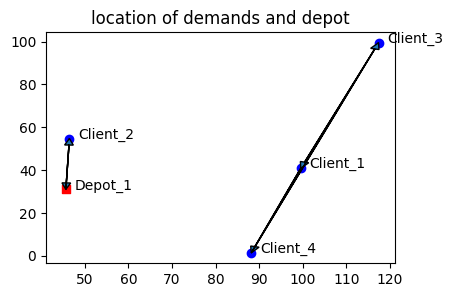

In [20]:
Clients = Locations[Locations['Type']=="Client"]
plt.scatter(Clients["Latitude"], Clients["Longitude"], c='b')
for i in range(0,number_of_clientes):
    plt.annotate(Clients["Name"].values[i], (Clients["Latitude"].iloc[i]+2, Clients["Longitude"].iloc[i]))

Depots = Locations[Locations['Type']=="Depot"] 
plt.scatter(Depots["Latitude"], Depots["Longitude"],c='r', marker='s')

for i in range(0,number_of_depots):
    plt.annotate(Depots["Name"].values[i], (Depots["Latitude"].iloc[i]+2, Depots["Longitude"].iloc[i]))  


for i in active_paths.itertuples():

    Origin_coord = Locations[Locations["Name"]==i.Origin][["Latitude","Longitude"]].values[0]
    Destination_coord = Locations[Locations["Name"]==i.Destination][["Latitude","Longitude"]].values[0]
    drawArrow(Origin_coord, Destination_coord) 
    
plt.title("location of demands and depot");   

In [21]:
loading_paths = sm.InputTables['Distances'][["Origin","Destination"]]
loading_paths =loading_paths [loading_paths["Origin"].isin(Clients['Name'])]
loading_paths =loading_paths [loading_paths["Destination"].isin(Clients['Name'])]
loading_paths.head(3)

,Origin,Destination
0,Client_1,Client_2
1,Client_1,Client_3
2,Client_1,Client_4
